# Demonstrating postprocess features of OptimUS


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates postprocessing functionalities implemented to visualise the calculated fields. 

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import sys
sys.path.append('..')

In [2]:
import optimus

## Set postprocessing parameters

The postprocessing parameters includes settings for calculating and visualisating the scattered field.

In [3]:
optimus.global_parameters.print()


Verbosity parameter: False

BEM parameters:
 Matrix assembly type:  hmat
  H-matrix epsilon for boundary operators: 0.001
  H-matrix maximum rank for boundary operators: 30
  H-matrix maximum block size for boundary operators: 1000000
 Field assembly type:  dense
 Numerical quadrature order.
  Double integration for boundary operators in the matrix.
   Self interaction: 6
   Near interaction: 4
   Medium interaction: 3
   Far interaction: 2
  Single integration for potential operators for the field.
   Near interaction: 4
   Medium interaction: 3
   Far interaction: 2

Linear algebra parameters:
 Linear solver: gmres
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Incident field parallel processing parameters:
 Parallelisation method: numba

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None
 Calderón pr

For example, the potential operators used to calculate the scattered field from the surface potential has two modes: `dense` and `hmat`. The latter option used hierarchical matrix compression.

In [4]:
optimus.global_parameters.bem.set_field_assembly_type('hmat')

In [5]:
optimus.global_parameters.bem.print()

Matrix assembly type:  hmat
 H-matrix epsilon for boundary operators: 0.001
 H-matrix maximum rank for boundary operators: 30
 H-matrix maximum block size for boundary operators: 1000000
Field assembly type:  hmat
 H-matrix epsilon for potential operators: 1e-08
 H-matrix maximum rank for potential operators: 10000
 H-matrix maximum block size for potential operators: 10000
Numerical quadrature order.
 Double integration for boundary operators in the matrix.
  Self interaction: 6
  Near interaction: 4
  Medium interaction: 3
  Far interaction: 2
 Single integration for potential operators for the field.
  Near interaction: 4
  Medium interaction: 3
  Far interaction: 2


In the case of hierarchical matrix compression, additional parameters can be set. Generally speaking, using dense mode is more accurate and sufficiently fast for smaller numbers of visualistion points.

In [6]:
optimus.global_parameters.bem.set_field_assembly_type('dense')

## Specify the physical settings for the simulation

Let us consider two spherical objects embedded in an unbounded region of water. One of the domains consists of fat and the other of cortical bone. The incident plane wave has a frequency of 100 kHz and the two spheres have a radius of 7 and 5 mm, respectively.

In [7]:
frequency = 200e3
source = optimus.source.create_planewave(frequency, direction=(1,0,0))

In [8]:
radii = (7e-3, 5e-3)
origins = ((-10e-3,0,0), (10e-3,0,0))
meshwidth = 2e-3

geometry_left = optimus.geometry.shapes.Sphere(radius=radii[0], origin=origins[0], element_size=meshwidth)
geometry_right = optimus.geometry.shapes.Sphere(radius=radii[1], origin=origins[1], element_size=meshwidth)
geometries = (geometry_left, geometry_right)

In [9]:
material_ext = optimus.material.load_material('water')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material_left, material_right = materials_int

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [10]:
model = optimus.model.create_acoustic_model(source, geometries, material_ext, materials_int)

Solving the model requires the GMRES algorithm to solve the system of boundary integral equations. This can be computationally expensive depending on the grid resolution.

In [11]:
model.solve()

## Visualisation of the acoustic field

The OptimUS library provides different functionality to visualise the simulation results.

In [12]:
%matplotlib inline

### Field visualisation on a plane

Let us create a postprocess object and define the 2D plane to determine the field. The input argument of the VisualisePlane object is the model object we created before.

In [13]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)

In [14]:
postprocess_plane.create_computational_grid(
    resolution=(111,131),
    plane_axes=(0,1),
    plane_offset=0,
    bounding_box=(-20e-3, 18e-3, -10e-3, 13e-3),
)

Here, `resolution` defines the number of points along each axis of the plane, i.e. `(N_axis1, N_axis_2)`, where the axes are labeled as follows: (0,1,2) for (x,y,z) in a Cartesian coordinate system. The `plane_offset` defines the offset along the third axis (perpendicular to the plane) and the `bounding_box` defines the limits of the plane as follows: `(axis1_min, axis1_max, axis2_min, axis2_max)`. If the plane does not intersect with all domains, a warning will be returned. 

Now, we can calculate the scattered and total pressure fields on this plane. This can be computationally expensive depending on the resolution.

In [15]:
postprocess_plane.compute_fields()

The field can be visualised as 2D contour plots. The input arguments are an optimus PostProcesses object, type of the pressure field and pressure unit (Pa, kPa, MPa, GPa).

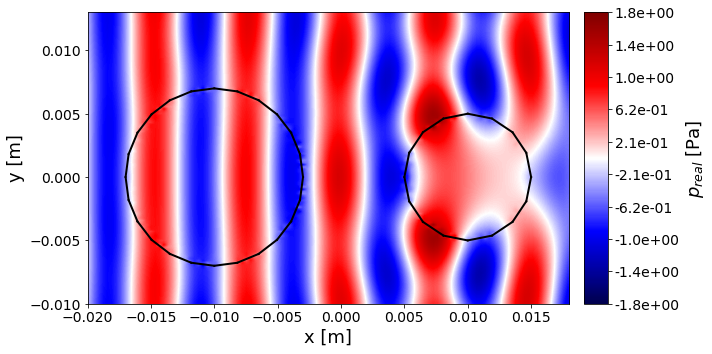

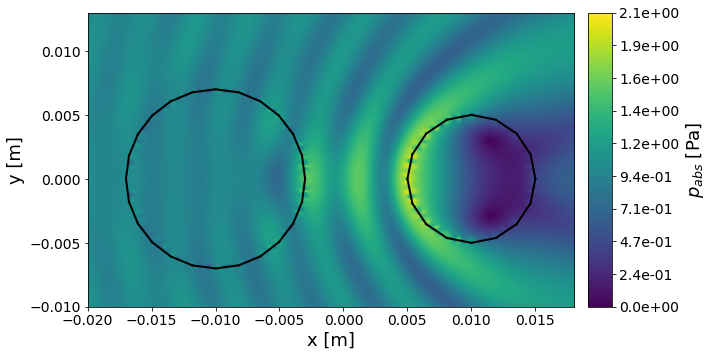

In [16]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total_pressure", unit='Pa')

Likewise, we can plot the scattered pressure field.

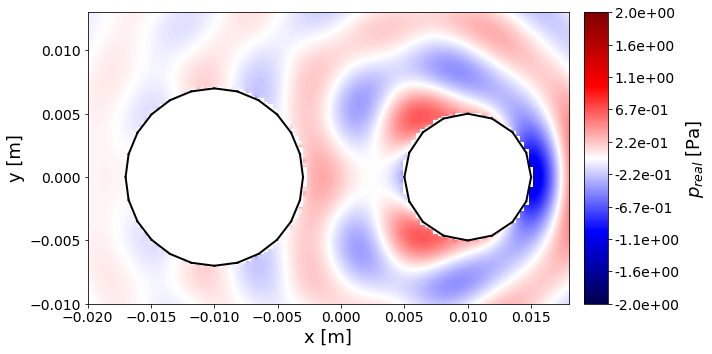

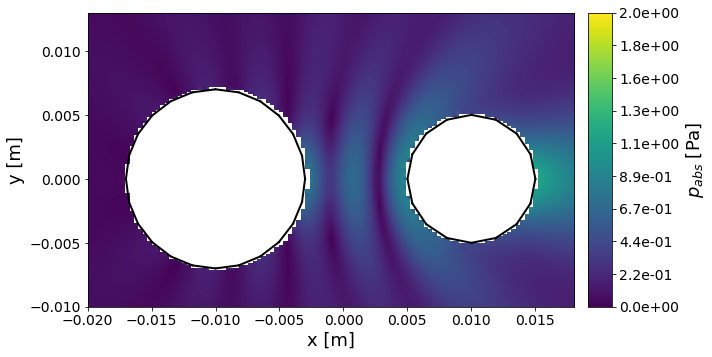

In [17]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane,field="scattered_pressure", 
                                               unit='Pa', 
                                               clim=(-2,2))

These figures can be saved (as a png, pdf, ps,...) files using savefig() method of a figure object, e.g. `figs[0].savefig('real_ptot.pdf')`.

Alternatively, the fields can be retrieved from the PostProcess object and used for manual plotting.

The `total_field` and `total_field_imshow` attributes of the `postprocess_plane` object gives the calculated total pressure field in the visualisation plane, with the shapes of `(resolution[0] * resolution[1],)`, and `(resolution[0], resolution[1])`, respectively. This method automatically detects the intersection of the plane with each domain and save the points in a list called `domains_edges`.

In [18]:
import numpy as np
from matplotlib import pylab as plt

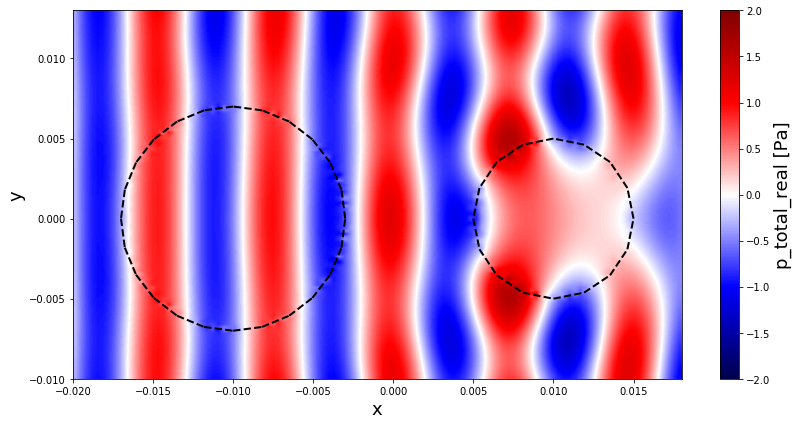

In [19]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(np.real(postprocess_plane.total_field_imshow), 
           extent=postprocess_plane.bounding_box, 
           clim=(-2,2), 
           cmap='seismic', 
           interpolation='bilinear')

if len(postprocess_plane.domains_edges):
    for i, j in postprocess_plane.domains_edges:
        plt.plot(i, j, color = 'black', linestyle='dashed' ,linewidth=2)
        
plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
cbar = plt.colorbar()
cbar.set_label("p_total_real [Pa]", size=18)
fig.tight_layout()
plt.show()

#### Visualisation of subdomains on a plane

So far, the plane cut through all subdomains, but the visualisation code is generic and we can compute the potentials anywhere in the space, inside and/or outside of each/all domains. Let's do an example where the visualisation plane is only around the left interface of subdomain 2 (the right sphere). 

In [20]:
postprocess_plane_subdomain = optimus.postprocess.VisualisePlane(model)

In [21]:
postprocess_plane_subdomain.create_computational_grid(
    resolution=(111,121),
    plane_axes=(0,1),
    plane_offset=0,
    bounding_box=(4e-3, 7e-3, -5e-3, 5e-3),
)

In [22]:
postprocess_plane_subdomain.compute_fields()

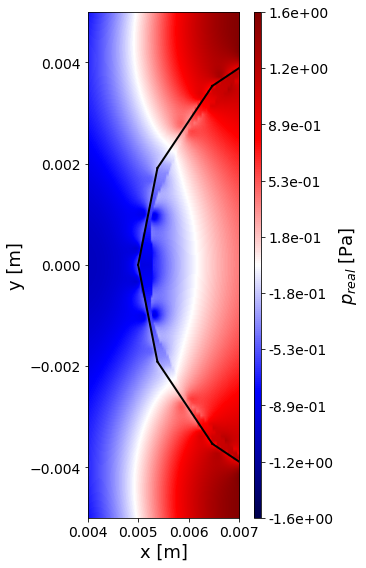

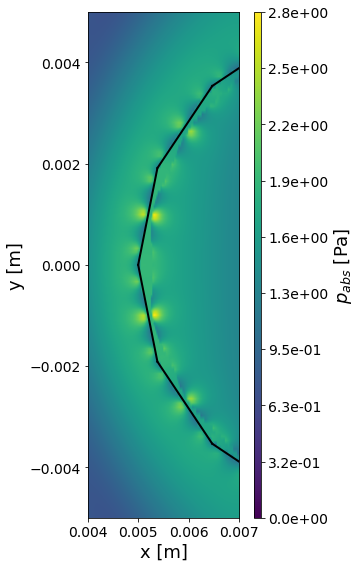

In [23]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane_subdomain, field="total_pressure", unit='Pa')

This is a useful feature to achieve detailed presentation of a field across a small area with no need to increase resolution, hence computational costs.

### Visualisation on arbitrary points

The acoustic field can be calculated on any (list of) points in space. Here, let us create points on a plane. The input argument of the `VisualiseCloudPoints` object is the model object we created before.

In [24]:
postprocess_cloud = optimus.postprocess.VisualiseCloudPoints(model)

In [25]:
# Create a visualisation grid
Nx, Ny = 51, 51
xmin, xmax, ymin, ymax  = [-20e-3, 18e-3, -10e-3, 13e-3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

In [26]:
postprocess_cloud.create_computational_grid(points=points)

In [27]:
postprocess_cloud.compute_fields()

To display the fields using the Matplotlib `imshow` function, we need to reshape and correct the format of the pressure values using the `array_to_imshow` function of OptimUS.

In [28]:
total_field_imshow = optimus.postprocess.common.array_to_imshow(
    postprocess_cloud.field.total_field.reshape((Nx,Ny)) )

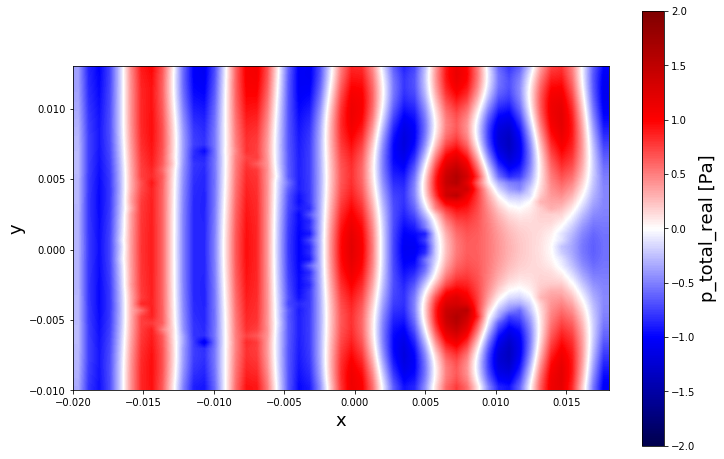

In [29]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(total_field_imshow), 
           extent=[xmin, xmax, ymin, ymax], 
           clim=(-2,2), 
           cmap='seismic', 
           interpolation='bilinear')

plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
cbar = plt.colorbar()
cbar.set_label("p_total_real [Pa]", size=18)
plt.show()

## Save/import a session

All the parameters, settings, BEM solutions and calculated fields can be saved as a database (db) file.

In [30]:
optimus.postprocess.export_to_file(model=model, 
                                   post_process=postprocess_plane, 
                                   global_parameters=optimus.global_parameters)

The data are written to the file: optimus_exported_data.db
The list of keys are: ['global_parameters', 'post_process', 'model', 'source']


The database file can be imported using the `import_from_file` function.

In [31]:
imported_db = optimus.postprocess.import_from_file('optimus_exported_data.db')

In [32]:
imported_db['model'].solution_vector[:10]

array([-0.89580992+0.38605227j, -0.05303188+1.12535184j,
        0.11029059+1.11446885j,  0.80322443+0.61576977j,
        0.80596262-0.45733786j,  0.90008007+0.43177971j,
        0.7573995 -0.54476688j,  0.26744261-0.96711485j,
        0.046465  +1.11811084j, -0.88377169+0.40602264j])

*Disclaimer:* it should be noted that Scipy operators and OptimUS LHS/RHS continuous/discrete matrices/vectors are not pickable, hence cannot be saved. Therefore for any re-run of the problem they will need to be calculated again.